In [ ]:
import pandas as pd
import os
import shapely
import geopandas
import pyproj


os.chdir("/Users/anorawu/Documents/GitHub/CloudSeeding/data/炮台数据")
df = pd.read_csv('df_merge_nodup_coord.csv')

df=df[df["coordinate_level"]!='市']
df=df[df["coordinate_level"]!='Not Found']
df=df[df["coordinate_level"]!='区县']

df = df[~df["location"].str.contains("请返回", na=False)]

for index,row in df.iterrows():
    if str(row['prov']) not in str(row['formatted_address']):
        df.drop(index=index, inplace=True)

df['operation_date'] = pd.to_datetime(dict(year=df.operation_year, month=df.operation_month, day=df.operation_day))
df['first_operation_date'] = df.groupby('coordinate')[['operation_date']].transform('min')
df.drop_duplicates(['operation_date','coordinate'],inplace=True)
df[['longitude', 'latitude']] = df['coordinate'].str.split(",", expand=True).astype(float)

df['point'] = df.apply(lambda x: shapely.Point((x.longitude, x.latitude)), axis = 1)


gdf = geopandas.GeoDataFrame(df, geometry=df.point, crs={'init': 'epsg:4326'})
aeqd = pyproj.Proj(proj='aeqd', ellps='WGS84', datum='WGS84').srs
gdf = gdf.to_crs(crs=aeqd)


gdf['circle_10km'] = gdf.geometry.buffer(10000)
gdf.set_geometry('circle_10km', drop=True, inplace=True)
gdf.drop(columns=['point'],inplace=True)
gdf = gdf.to_crs(crs={'init': 'epsg:4326'})

gdf.drop(columns=['operation_date'],inplace=True)
gdf['first_operation_date']=gdf['first_operation_date'].astype(str)
gdf.to_file('cleaned_炮台数据.shp')

/opt/anaconda3/envs/cloud/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/envs/cloud/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/5h/rb902v091ys_0c5x0jt8sbjw0000gp/T/ipykernel_25098/2782095852.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file

<Axes: >

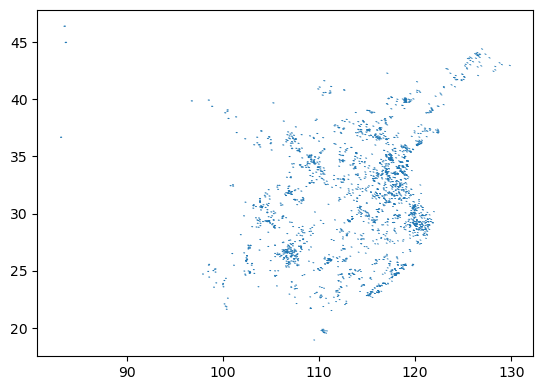

In [37]:
gdf.plot()